<span style="font-size: 14pt">MIPT, Applied ML, Autumn 2018</span> 

<span style="font-size: 16pt"> HW#1 </span>

<span style="color:red; font-size: 16pt"> deadline: 22.09.2018 23:59 </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Organization Info</h1> 

# Modules: utils, tests

In [0]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

# Quality functions
def qualitySSE(x,y):
    # Sum squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).sum(), (x-y)**2

def qualityMSE(x,y):
    # Mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).mean() , (x-y)**2

def qualityRMSE(x,y):
    # Root mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (((x-y)**2).mean())**(0.5) , (x-y)**2

def qualityMAE(x,y):
    # Mean absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (x-y).abs().mean(), (x-y).abs()

def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()

def InitExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha*(t-t0+1)/(AdaptationPeriod)) + alpha*(t-t0+1)/(AdaptationPeriod)*x[t]
            y = y*(1-alpha) + alpha*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST	

# AdaptiveExponentialSmoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    AdaptivePeriod scalar> - adapation period for initialization
#    gamma<scalar in [0,1]> - parametr of cross validation

def AdaptiveExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = np.NaN
    t0= np.NaN
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
                e1=alpha
                e2 = 1
            else:
                if (t-t0)<h:
                    e1 = gamma*(x[t]-y)+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-y)+(1-gamma)*e2
                else:
                    e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            
            if e2==0:
                K=alpha
            else:
                K=np.abs(e1/e2)

            alpha=Kt_1
            Kt_1=K

            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y
    return FORECAST

def WintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    s= []
    for i in range(p):
        if not math.isnan(x[i]):
            s.append(x[i])
        else:
            s.append(s[i-1])
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if len(s)==0:
                for i in range(p):
                    s.append(x[i])
            if cntr<p:
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*l # recurrent smoothing of level 
            else:
                s_old=s[cntr%p]
                s[cntr%p]=gamma*(x[cntr]-l)+(1-gamma)*s[cntr%p]
                l = alpha*(x[cntr]-s_old)+(1-alpha)*l # recurrent smoothing of level 
                
                
        FORECAST[cntr+h] = l + s[(cntr+1)%p]
    return FORECAST

def TheilWageExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    b=np.NaN
    s= []
    for i in range(p):
        if not math.isnan(x[i]):
            s.append(x[i])
        else:
            s.append(s[i-1])

    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if math.isnan(b):
                b= 0
            if cntr<p:
                l_old=l
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*(l+b)
                b=beta*(l-l_old)+(1-beta)*b
            else:
                l_old=l
                s_old=s[cntr%p]
                l = alpha*(x[cntr]-s_old)+(1-alpha)*(l+b) # recurrent smoothing of level 
                b=beta*(l-l_old)+(1-beta)*b
        s[cntr%p]=gamma*(x[cntr]-l)+(1-gamma)*s[cntr%p]
            
        FORECAST[cntr+h] = l+b + s[(cntr+h)%p]
    return FORECAST

def build_forecast(h, ts, algname, algtitle, params_array, step='D'):
    FRC_TS = dict()

    for p in params_array:
        frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
        frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)
        
        for cntr in ts.columns:
            frc_ts[cntr] = eval(algname)(ts[cntr], h, p)
        
#         frc_ts.columns = frc_ts.columns+('%s %s' % (algtitle, p))
#         print('%s %s' % (algtitle, p))
        FRC_TS['%s %s' % (algtitle, p)] = frc_ts
    
    return FRC_TS

def plot_tsforecast(ts, frc_ts, ts_num=0, alg_title=''):
    frc_ts.columns = ts.columns+'; '+alg_title
    ts[ts.columns[0]].plot(style='b', linewidth=1.0, marker='o')
    ax = frc_ts[frc_ts.columns[0]].plot(style='r-^', figsize=(15,5), linewidth=1.0)
    plt.xlabel("Time ticks")
    plt.ylabel("TS values")
    plt.legend()
    return ax


In [0]:
# Author   : John Tsang
# Date     : December 7th, 2017
# Purpose  : Implement the Diebold-Mariano Test (DM test) to compare 
#            forecast accuracy
# Input    : 1) actual_lst: the list of actual values
#            2) pred1_lst : the first list of predicted values
#            3) pred2_lst : the second list of predicted values
#            4) h         : the number of stpes ahead
#            5) crit      : a string specifying the criterion 
#                             i)  MSE : the mean squared error
#                            ii)  MAD : the mean absolute deviation
#                           iii) MAPE : the mean absolute percentage error
#                            iv) poly : use power function to weigh the errors
#            6) poly      : the power for crit power 
#                           (it is only meaningful when crit is "poly")
# Condition: 1) length of actual_lst, pred1_lst and pred2_lst is equal
#            2) h must be an integer and it must be greater than 0 and less than 
#               the length of actual_lst.
#            3) crit must take the 4 values specified in Input
#            4) Each value of actual_lst, pred1_lst and pred2_lst must
#               be numerical values. Missing values will not be accepted.
#            5) power must be a numerical value.
# Return   : a named-tuple of 2 elements
#            1) p_value : the p-value of the DM test
#            2) DM      : the test statistics of the DM test
##########################################################
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of 
#   prediction mean squared errors. International Journal of forecasting, 
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy, 
#   Journal of business & economic statistics 13(3), 253-264.
#
##########################################################
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

# BEGIN

**Дополнительный материал для выполнения дз**:
- Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.
- Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11

**Оформление дз**: 
- Выполненное задание требуется отправлять через <a href='https://goo.gl/forms/XPSIbwp7wPxB4SsI3'>форму </a>
    - <span style="color:red; font-size: 20pt">ВНИМАНИЕ: для отправки задания потребуется почта в домене gmail.com или phystech.edu</span>
    
- Укажите тему письма в следующем формате ``ML2018_fall_<номер_группы>_<фамилия>``, к примеру -- ``ML2018_fall_594_ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipynb``, к примеру -- ``ivanov_401_task1.ipynb``

**Вопросы**:
- Вопросы присылайте на почту ml.course.mipt@gmail.com
- Укажите тему письма в следующем формате ``ML2018_fall_Question_<Тема вопроса>``

--------
- **PS1**: Будьте внимательны при заполнении формы, когда отправляете ДЗ 

<h1 align="center">Теоретическая часть (15%)</h1> 

Ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: Пусть дан временной ряд $y_t = \delta\cdot t + \varepsilon_t$, где $\varepsilon_t$ - случайная величина с нулевым матожиданием и не зависящей от времени дисперсией $\sigma$, $E \varepsilon_t \varepsilon_{t+k}=0$ при $k\not=0$, Докажите, что оптимальное значение параметра сглаживания $\alpha$ в алгоритме простого экспоненциального сглаживания для такого временного ряда будет равно 1.

<Ответ> \


**Вопрос 2**: Докажите  эквивалетность формул расчёта (в рекуррентной форме и в форме корректировки прогноза (correction error form) )скрытых компонент временного ряда для модели линейного затухающего тренда:

$$ l_{t}= \alpha y_t + \left(1-\alpha\right) \left(l_{t-1} +\phi b_{t-1}\right)\color{red}{=}l_{t-1} +\phi b_{t-1} + \alpha e_t$$,
$$ b_t         = \beta \left(l_t - l_{t-1}\right) + \left(1-\beta\right)\phi b_{t-1}\color{red}{=}\phi b_{t-1} +  \alpha\beta e_t.$$

<Ответ> см. прикреп.

**Вопрос 3**: Выведите формулу расчёта скрытых компонент в форме корректировки прогноза (correction error form) временного ряда в модели ЭС с мультипликативным затухающим трендом (WS with multiplicative damped trend):
   
### \begin{align*}
		\hat{y}_{t+d|t} &= l_t b_t^{\left(\phi + \phi^2 + \dots + \phi^{d}\right)}, \\
		l_{t}       &= \alpha y_t + \left(1-\alpha\right) l_{t-1} b_{t-1}^{\phi}, \\
		b_t         &= \beta\frac{l_t}{l_{t-1}} + \left(1-\beta\right)b_{t-1}^{\phi}.
\end{align*}
		

<Ответ>см. прикреп.

-----------
PS: Если проверяющий не понял ответ на большинство вопросов, то будет пичалька. Пишите так, чтобы можно было разобраться. 

In [154]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

upload_files()

Saving IMG_20180924_223253677.jpg to IMG_20180924_223253677.jpg
Saving IMG_20180924_223314404.jpg to IMG_20180924_223314404.jpg
Saving IMG_20180924_223302265.jpg to IMG_20180924_223302265.jpg


['IMG_20180924_223253677.jpg',
 'IMG_20180924_223314404.jpg',
 'IMG_20180924_223302265.jpg']

Populating the interactive namespace from numpy and matplotlib


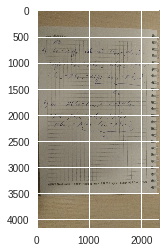

In [155]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('IMG_20180924_223253677.jpg')
imgplot = plt.imshow(img)
plt.show()                     
# хм.... неплохо

In [0]:
import numpy as np
import cv2

# Load an color image in grayscale
img = cv2.imread('IMG_20180924_223253677.jpg',0)
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()
#коллаб убивает рантайм

In [0]:
from PIL import Image
im = Image.open("IMG_20180924_223253677.jpg")
im.show()
#so what?!

In [0]:
from IPython.display import Image 
Image(filename='IMG_20180924_223253677.jpg')
# хороший зум.

Решения: https://drive.google.com/drive/folders/14OxppNXfNOGKCNlZsnjllSmB5cg30Q7Q?usp=sharing  \
[Решения](https://drive.google.com/drive/folders/14OxppNXfNOGKCNlZsnjllSmB5cg30Q7Q?usp=sharing)

<h1 align="center"> Реализация алгоритма из семейства ES (85%) </h1>

Суть задания: реализовать, применить на данных monthly_wage модель Уинтерса с линейным трендом. 
## $$\hat y_{t+d} = (l_t + b_t d) \cdot s_{t + (d \bmod p) -p}.$$
Результат нужно сравнить с прогнозом модели Тейла-Вейджа.

### Датасет из 2017/seminars/1_ts_esm/data

In [2]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

upload_files()

Saving monthly-wage.csv to monthly-wage.csv


['monthly-wage.csv']

In [0]:
# start with this code
import pandas as pd
import numpy as np
# rom utils import TheilWageExponentialSmoothing, build_forecast, plot_tsforecast
# from utils import qualityRMSE, qualityMedianAE, qualityMACAPE, qualitySSE, qualityMSE, qualityMAPE 

%matplotlib inline


### Начальные данные

(289, 1)


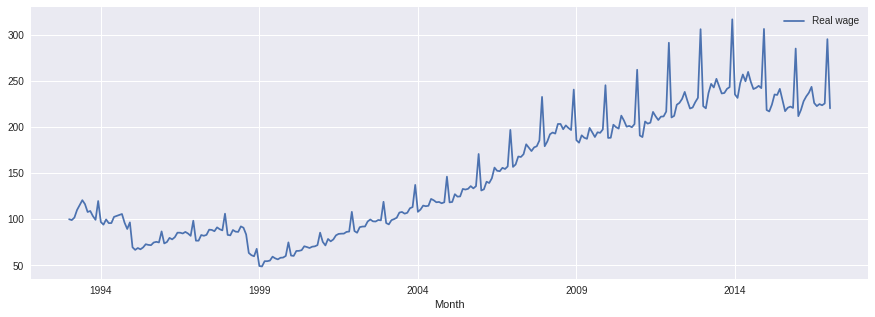

In [44]:
wage = pd.read_csv('monthly-wage.csv', sep=';', decimal='.', index_col=0, parse_dates=True, dayfirst=True)

print(wage.shape)
# # Put your code below
wage.plot(figsize=(15,5))

# 1. Build the Forecast with Theil-Wage Model (25%)

You need to apply Theil-Wage (TWES) model (see seminar 1) for the TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.


* 0) Forecast Wage TS with Theil-Wage $\alpha=.1, \beta=0.3, \gamma=0.3$.
* 1) Find the best param $\alpha, \beta, \gamma$ of Theil-Wage for data period from 09.1998 to 01.2015. 
* 2) Draw the forecast that correspond to TWES with optimial value $\alpha$ (use time steps from 09.1998 to 01.2017.)
     Conclude whether TWES can be used for this TS? If can not than explain why.
* 3) Calculate loss of the forecast of TS in [02.2015, 01.2017]. (You can choose any Loss function from seminar 1).

## 0) Forecast Wage TS with Theil-Wage α=.1,β=0.3,γ=0.3.

In [0]:
ALPHA = 0.1
BETA = 0.3
GAMMA = 0.3
twes_params_array = [{'beta':BETA, 'gamma':GAMMA, 'alpha':ALPHA, 'AdaptationPeriod':10, 'seasonality_period':7}]
forecast = build_forecast(1, ts=wage, algname = 'TheilWageExponentialSmoothing', algtitle='TWES', params_array=twes_params_array, step='D')

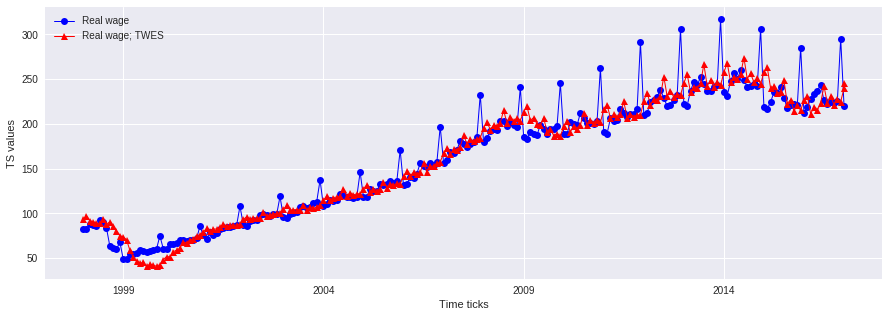

In [46]:
algName = "TWES {'beta': 0.3, 'gamma': 0.3, 'alpha': 0.1, 'AdaptationPeriod': 10, 'seasonality_period': 7}"
plot_tsforecast(wage.loc['1998-01':'2017-01'], forecast[algName].loc['1998-01':'2017-01'],ts_num=0, alg_title='TWES')

## 1) Search for the optimal $\alpha$, $\beta$, $\gamma$ (10%)

In [0]:
ALPHA = np.arange(0.0, 1, 0.1)
BETA = np.arange(0.0, 1, 0.1)
GAMMA =  np.arange(0.0, 1, 0.1)
twes_params_array = [{'beta':beta, 'gamma':gamma, 'alpha':alpha, 'AdaptationPeriod':10, 'seasonality_period':12} for gamma in GAMMA for beta in BETA for alpha in ALPHA]
forecast_TW = build_forecast(h=1, ts=wage, algname =  'TheilWageExponentialSmoothing', algtitle='TW',params_array = twes_params_array)

In [48]:
print(wage.columns)
print(forecast_TW.keys())

Index(['Real wage'], dtype='object')
dict_keys(["TW {'beta': 0.0, 'gamma': 0.0, 'alpha': 0.0, 'AdaptationPeriod': 10, 'seasonality_period': 12}", "TW {'beta': 0.0, 'gamma': 0.0, 'alpha': 0.1, 'AdaptationPeriod': 10, 'seasonality_period': 12}", "TW {'beta': 0.0, 'gamma': 0.0, 'alpha': 0.2, 'AdaptationPeriod': 10, 'seasonality_period': 12}", "TW {'beta': 0.0, 'gamma': 0.0, 'alpha': 0.30000000000000004, 'AdaptationPeriod': 10, 'seasonality_period': 12}", "TW {'beta': 0.0, 'gamma': 0.0, 'alpha': 0.4, 'AdaptationPeriod': 10, 'seasonality_period': 12}", "TW {'beta': 0.0, 'gamma': 0.0, 'alpha': 0.5, 'AdaptationPeriod': 10, 'seasonality_period': 12}", "TW {'beta': 0.0, 'gamma': 0.0, 'alpha': 0.6000000000000001, 'AdaptationPeriod': 10, 'seasonality_period': 12}", "TW {'beta': 0.0, 'gamma': 0.0, 'alpha': 0.7000000000000001, 'AdaptationPeriod': 10, 'seasonality_period': 12}", "TW {'beta': 0.0, 'gamma': 0.0, 'alpha': 0.8, 'AdaptationPeriod': 10, 'seasonality_period': 12}", "TW {'beta': 0.0, 'gamma

In [49]:
# find best TWES parameters
# from 09.1998 to 01.2015. 
QualityStr = pd.DataFrame(index = wage.columns, columns = forecast_TW.keys())

ix = wage.loc['1998-09':'2015-01'].index  
print(ix)
for param_cntr in sorted(QualityStr.columns):
  frc_wage = forecast_TW[param_cntr]
  QualityStr[param_cntr],_ = qualityMAE(wage.loc[ix], frc_wage.loc[ix])

DatetimeIndex(['1998-09-01', '1998-10-01', '1998-11-01', '1998-12-01',
               '1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01',
               '1999-05-01', '1999-06-01',
               ...
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01'],
              dtype='datetime64[ns]', name='Month', length=197, freq=None)


In [51]:
QualityStr[QualityStr.columns].mean().sort_values()

TW {'beta': 0.0, 'gamma': 0.9, 'alpha': 0.5, 'AdaptationPeriod': 10, 'seasonality_period': 12}                                                      3.754172
TW {'beta': 0.0, 'gamma': 0.8, 'alpha': 0.5, 'AdaptationPeriod': 10, 'seasonality_period': 12}                                                      3.780682
TW {'beta': 0.1, 'gamma': 0.7000000000000001, 'alpha': 0.30000000000000004, 'AdaptationPeriod': 10, 'seasonality_period': 12}                       3.852626
TW {'beta': 0.1, 'gamma': 0.6000000000000001, 'alpha': 0.30000000000000004, 'AdaptationPeriod': 10, 'seasonality_period': 12}                       3.853555
TW {'beta': 0.0, 'gamma': 0.9, 'alpha': 0.4, 'AdaptationPeriod': 10, 'seasonality_period': 12}                                                      3.857293
TW {'beta': 0.0, 'gamma': 0.8, 'alpha': 0.4, 'AdaptationPeriod': 10, 'seasonality_period': 12}                                                      3.872558
TW {'beta': 0.1, 'gamma': 0.7000000000000001, 'alpha': 0.4

## 2) draw the forecast with optimial value $\alpha $  (10%)

TW {'beta': 0.0, 'gamma': 0.9, 'alpha': 0.5, 'AdaptationPeriod': 10, 'seasonality_period': 12}


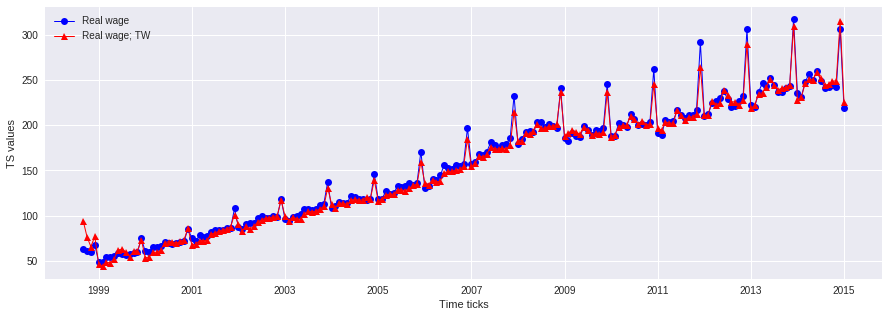

In [52]:
# example of code:
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
print(algName)
plot_tsforecast(wage.loc[ix], forecast_TW[algName].loc[ix], ts_num=0, alg_title="TW") # Wow, such scale, much points, so ....

$\beta \rightarrow 0. Where  \beta$--- is the smoothing parameter for the trend

## 3) Calculate loss of the forecast of TS in [02.2015, 01.2017] (5%)

In [53]:

qualityMAE(wage.loc['02-2015':'01-2017'], forecast_TW[algName].loc['02-2015':'01-2017'])[0]

Real wage    4.187774
dtype: float64

# 2. Non-additive model of ES (60%)
You need to realize Winters model with linear trend and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.


### Немного теории
The additive method is preferred when the seasonal variations are roughly constant through the series \
The multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series \
Within each year, the seasonal component will add up to approximately zero \

https://otexts.org/fpp2/holt-winters.html   <-- Идеально

## 1) Realize Winters Model with Linear trend (20%)

In [0]:
# Start with this code
###################### Winters Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter of level
#    beta <scalar in [0,1]> - smoothing parameter of trend
#    gamma <scalar in [0,1]> - smoothing parameter of seasonality
def WintersLinearTrendExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN] * (T+h)## put foreast of the model here
    
    l= np.NaN # initialize ts level 
    b = np.NaN # initialize ts trend
    s= np.zeros(p) # initalize seasonality values (it must be vector of lenth p)
   
    x_means = np.mean(x[:p])
    for i in range(p):
        if not math.isnan(x[i]):
            s[i] = x[i] / x_means
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            prev_l=l
            prev_b=b
            if math.isnan(l):
                l= x[cntr]     # initialize
                prev_b = 0     
                prev_l = l
            if math.isnan(s[cntr % p]):
                s[cntr % p]= 0    # initialize 
            
            s_pre_season = s[cntr % p]
            l = alpha * (x[cntr]/s_pre_season) + (1 - alpha) * (prev_l + prev_b)    # recurrent smoothing of level
            b = beta * (l - prev_l) + (1 - beta) * prev_b    # recurrent smoothing of trend
            s[cntr % p] = gamma * (x[cntr] / (prev_l + prev_b)) + (1 - gamma) * s[cntr%p]    # recurrent smoothing of seasonality
        # print(type(cntr), type(h), type((cntr+h) % s)) #gpi;haersgklesjf 's'???
        FORECAST[cntr+h] = (l + h*b) * s[(cntr+h) % p]
    return FORECAST

## 2) Find optimal params of the model (10%)
(use data from 09.1998 to 01.2015). (Loss function should be the same as for Theil-Wage model)

In [0]:
ALPHA = np.arange(0.0, 1, 0.1)
BETA = np.arange(0.0, 1, 0.1)
GAMMA = np.arange(0.0, 1, 0.1)

twes_params_array = [{'beta':beta, 'gamma':gamma, 'alpha':alpha, 'AdaptationPeriod':12, 'seasonality_period':12} for gamma in GAMMA for beta in BETA for alpha in ALPHA]
forecast_Winter = build_forecast(h=1, ts=wage, algname =  'WintersLinearTrendExponentialSmoothing', algtitle='Winter_linear',params_array = twes_params_array)

In [0]:
# Put your code here
# find best TWES parameters
# from 09.1998 to 01.2015. 
QualityStr = pd.DataFrame(index = wage.columns, columns = forecast_Winter.keys())

ix = wage.loc['1998-09':'2015-01'].index  
# print(ix)
for param_cntr in sorted(QualityStr.columns):
  frc_wage = forecast_Winter[param_cntr]
  QualityStr[param_cntr],_ = qualityMAE(wage.loc[ix], frc_wage.loc[ix])

In [57]:
QualityStr[QualityStr.columns].mean().sort_values()

Winter_linear {'beta': 0.0, 'gamma': 0.5, 'alpha': 0.7000000000000001, 'AdaptationPeriod': 12, 'seasonality_period': 12}                                       2.914538
Winter_linear {'beta': 0.0, 'gamma': 0.5, 'alpha': 0.6000000000000001, 'AdaptationPeriod': 12, 'seasonality_period': 12}                                       2.933726
Winter_linear {'beta': 0.0, 'gamma': 0.6000000000000001, 'alpha': 0.7000000000000001, 'AdaptationPeriod': 12, 'seasonality_period': 12}                        2.939023
Winter_linear {'beta': 0.1, 'gamma': 0.5, 'alpha': 0.5, 'AdaptationPeriod': 12, 'seasonality_period': 12}                                                      2.955209
Winter_linear {'beta': 0.1, 'gamma': 0.4, 'alpha': 0.5, 'AdaptationPeriod': 12, 'seasonality_period': 12}                                                      2.980515
Winter_linear {'beta': 0.0, 'gamma': 0.6000000000000001, 'alpha': 0.6000000000000001, 'AdaptationPeriod': 12, 'seasonality_period': 12}                        2

## 3) Draw forecast with optimal values of it's params (10%)
(data from 09.1998 to 01.2017)

[217.18686576 221.21427875]


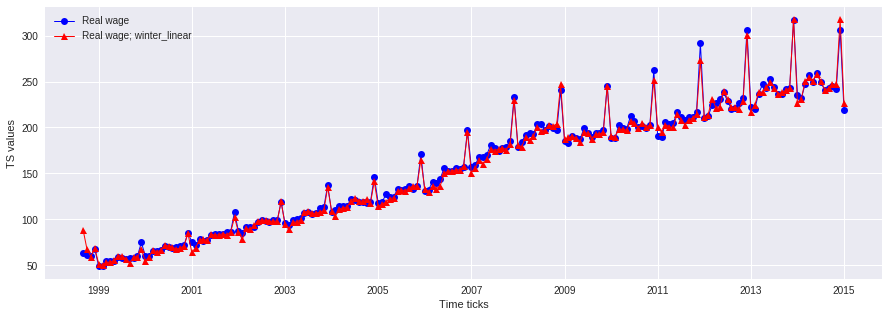

In [58]:
# Put your code here

algName_for_winter = QualityStr[QualityStr.columns].mean().sort_values().index[0]
print(forecast_Winter[algName_for_winter].loc['2017-01'].values.flatten())
plot_tsforecast(wage.loc[ix], forecast_Winter[algName_for_winter].loc[ix], ts_num=0, alg_title="winter_linear")

## 4) Calculate accuracy of the forecast of TS in [02.2015, 01.2017] (10%)
(Loss function should be the same as for Theil-Wage model). 

In [59]:
# Put your code here
qualityMAE(wage.loc['2015-02':'2017-01'], forecast_Winter[algName_for_winter].loc['2015-02':'2017-01'])[0]

Real wage    3.365269
dtype: float64

## 5) Compare Winters Model with linear thend and Theil-Wage model (10%) 
Which forecast is better (more accurate)?
Is it true that multiplicative model is more appropriate then Theil-Wage Model to this time series?
Hint: you should use for example Diebold-Mariano test (see here https://github.com/johntwk/Diebold-Mariano-Test) to make a conclusion.

In [60]:
# Put your code here  
# print(len(wage.loc['2015-02': '2017-01'].values.flatten()))
# print(len(forecast_TW[algName].loc['2015-02':'2017-01'].values.flatten()))
# print(len(forecast_Winter[algName_for_winter].loc['2015-02':'2017-01'].values.flatten()))

# print(wage.loc['2015-02': '2017-01'].values.flatten())
# print(forecast_TW[algName].loc['2015-02':'2017-01'].values.flatten())
# print(forecast_Winter[algName_for_winter].loc['2015-02':'2017-01'].values.flatten())

rt = dm_test(wage.loc['2015-02': '2017-01'].values.flatten(),
             forecast_TW[algName].loc['2015-03':'2017-01'].values.flatten(),
             forecast_Winter[algName_for_winter].loc['2015-03':'2017-01'].values.flatten(),
             h = 1, crit="MSE")
print(rt)

rt = dm_test(wage.loc['1998-09':'2017-01'].values.flatten(),
             forecast_TW[algName].loc['1998-10':'2017-01'].values.flatten(),
             forecast_Winter[algName_for_winter].loc['1998-10':'2017-01'].values.flatten(),
             h = 1, crit="MSE")
print(rt)

dm_return(DM=1.6959362605605386, p_value=0.10339413074551056)
dm_return(DM=-2.4461840910844557, p_value=0.015222667825324528)


Conclusion: \
Если брать весь доступный период, то Theil-Wage хуже(видно по отрицательному p_value), но в  последнем промежутке (15-17) TW лучше.